In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import squarify

from helpers import fetch_area_data, get_variables
from tree import build_tree, fetch
from config import settings

In [2]:
print('51163 Rockbridge County, Virginia')
df, url = fetch_area_data('2021',4,'51163')

51163 Rockbridge County, Virginia


In [3]:
# https://www.bls.gov/cew/classifications/aggregation/agg-level-titles.htm
total_establishments = int(df[df['agglvl_code']==70][settings.establishments])
print(f"Total establishments in the county: {total_establishments}") 
aggregations = range(74,78+1)
for aggregation in aggregations:
    print(f"The sum of establishment counts at level {aggregation}: {np.sum(df[df['agglvl_code']==aggregation][settings.establishments])}")

Total establishments in the county: 542
The sum of establishment counts at level 74: 542
The sum of establishment counts at level 75: 542
The sum of establishment counts at level 76: 542
The sum of establishment counts at level 77: 542
The sum of establishment counts at level 78: 542


In [4]:
# cast data into a tree structure with nested mappings
# county = {'ind': 10, 'est': 533, 'emp': 5937, children': [{}, {}, ...]}
county = build_tree(df, '10', 70)
county

{'ind': '10',
 'est': 542,
 'emp': 5808,
 'children': [{'ind': '11',
   'est': 17,
   'emp': 0,
   'children': [{'ind': '111',
     'est': 1,
     'emp': 0,
     'children': [{'ind': '1119',
       'est': 1,
       'emp': 0,
       'children': [{'ind': '11199',
         'est': 1,
         'emp': 0,
         'children': [{'ind': '111998',
           'est': 1,
           'emp': 0,
           'children': []}]}]}]},
    {'ind': '112',
     'est': 9,
     'emp': 35,
     'children': [{'ind': '1121',
       'est': 7,
       'emp': 0,
       'children': [{'ind': '11211',
         'est': 5,
         'emp': 0,
         'children': [{'ind': '112111', 'est': 5, 'emp': 0, 'children': []}]},
        {'ind': '11212',
         'est': 2,
         'emp': 0,
         'children': [{'ind': '112120',
           'est': 2,
           'emp': 0,
           'children': []}]}]},
      {'ind': '1129',
       'est': 2,
       'emp': 0,
       'children': [{'ind': '11292',
         'est': 1,
         'emp': 0,
    

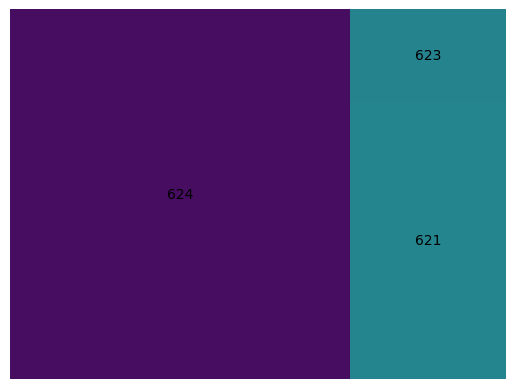

In [5]:
# Return industry details
industry = fetch(county, 'ind', '62')
sub_industries = [sub_industry['ind'] for sub_industry in industry['children']]
est = [sub_industry['est'] for sub_industry in industry['children']]

sub_industries_sorted = [ind for _, ind in sorted(zip(est, sub_industries), reverse=True)]
est_sorted = sorted(est, reverse=True)
squarify.plot(sizes=est_sorted, label=sub_industries_sorted)
plt.axis('off')
plt.show()

In [52]:
# IMPLAN example
industry = fetch(county, 'ind', '10')
print('*** overall number of establishments ***')
print(industry['est'])
print('*** overall employment ***')
print(industry['emp'])
print('*** sub industries ***')
print([sub_industry['ind'] for sub_industry in industry['children']])
print('*** number of establishments in the sub industries ***')
print([sub_industry['est'] for sub_industry in industry['children']])
print('*** employment in the sub industries ***')
print([sub_industry['emp'] for sub_industry in industry['children']])
print('*** employment approximation IMPLAN ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
employment = np.array([sub_industry['emp'] for sub_industry in industry['children']],dtype = object)
employment_implan = employment.copy()
undisclosed_est = np.sum(establishments[np.where(employment==0)])
undisclosed_emp = industry['emp'] - np.sum(employment)
employment_implan[np.where(employment==0)] = establishments[np.where(employment==0)]/undisclosed_est*undisclosed_emp
print(employment_implan)


*** overall number of establishments ***
542
*** overall employment ***
5808
*** sub industries ***
['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92', '99']
*** number of establishments in the sub industries ***
[17, 1, 4, 75, 25, 13, 62, 25, 9, 18, 9, 33, 2, 26, 7, 89, 14, 46, 41, 14, 12]
*** employment in the sub industries ***
[0, 0, 0, 369, 897, 0, 1196, 97, 29, 106, 18, 0, 0, 0, 69, 507, 112, 584, 148, 36, 17]
*** employment approximation IMPLAN ***
[287.40625 16.90625 67.625 369 897 219.78124999999997 1196 97 29 106 18
 557.90625 33.8125 439.56249999999994 69 507 112 584 148 36 17]


In [51]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = employment,
        name = 'employment'
    )
)
fig.add_trace(
    go.Bar(
        y = employment_implan,
        name = 'employment IMPLAN'
    )
)
fig.update_layout(
    title='Employment and employment approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)